Generate a graph showing 5v5 rolling CF%, GF%, boxcars, and percentages as in [this tweet](https://twitter.com/muneebalamcu/status/835923952065216512).
<p>First, import relevant packages and routines, and import seaborn to use its nicer-looking default aesthetic settings.

In [1]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import pandas as pd
import GetPbP
import matplotlib.patheffects as path_effects
import seaborn

Read in game-by-game data from 07-08 to present.

In [2]:
dfs = []
for season in range(2007, 2017):
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)
#dfs.head()

Set parameters:
<ul>
<li>player--player name. You may have to try a few different variations before it works.
<li>player position--D or F
<li>start date and end date--in yyyy-mm-dd format
<li>teams--relevant teams, or "all"
<li>roll length for GF% (and shooting percentage) graph
<li>roll length for CF% graph 
<li>roll length for the boxcar graph
<li>boolean for whether to include the playoffs
<li>filename to save to file, or "None" to simply display
<li>boolean for whether to index the x-axis on date (False) or game number (True)--former will result in horizontal lines over July, August, and September, which are a little ugly but make it easy to note offseasons
<li>boolean for whether boxcars should be rate stats or totals


In [3]:
player = "Alex Ovechkin"
pos = 'F'
start_date = '2011-09-15' #use mid-Sept to be safe because some seasons have Euro premiere games
end_date = '2017-06-21' #Format: yyyy-mm-dd

teams = 'all' #or, e.g. {'WSH'}, or {'WSH', 'T.B'}
roll_len_gf = 40 #in games; also applies to sh% and sv%
roll_len_boxcars = 40 
roll_len_cf = 25

include_playoffs = True #can also set to False
save_file = None #set to something to save figure
gapless = True #Will avoid long offseason flatlines (no games = no change in CF%)
ratestats = True #will divide by TOI if True
    
if teams == 'all':
    teams = GetPbP.TEAMS
if isinstance(teams, str):
    teams = {teams}

Filters down all the game-by-game data to the one fulfilling the player, team, and date requirements.

In [4]:
df = dfs[dfs.Player == player]
df = df[df.Team.apply(lambda x: x in teams)]

df['Date2'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.sort_values('Date2', inplace=True)
df.set_index('Date2', inplace=True)
df = df.ix[start_date : end_date]

if gapless:
    df.reset_index(inplace=True)

if not include_playoffs:
    df = df[df.Game <= 21230]

Calculate rolling stats

In [5]:
cols_to_use = ['GF', 'GA', 'CF', 'CA', 'iG', 'iA1', 'iA2', 'GFON']
base = '{0:d}-game '.format(roll_len_boxcars)

df[base + 'TOI'] = pd.rolling_sum(df['TOION(60s)'], roll_len_boxcars, 0)
if ratestats:
    divisor = df[base + 'TOI']
else:
    divisor = 1    

In [6]:
df[base + 'G'] = pd.rolling_sum(df['iG'], roll_len_boxcars, 0)/divisor
df[base + 'A1'] = pd.rolling_sum(df['iA1'], roll_len_boxcars, 0)/divisor
df[base + 'A2'] = pd.rolling_sum(df['iA2'], roll_len_boxcars, 0)/divisor
df[base + 'GFON_box'] = pd.rolling_sum(df['GFON'], roll_len_boxcars, 0)/divisor

In [7]:
df['{0:d}-game GFON'.format(roll_len_gf)] = pd.rolling_mean(df['GFON'], roll_len_gf, 0)
df['{0:d}-game GAON'.format(roll_len_gf)] = pd.rolling_mean(df['GAON'], roll_len_gf, 0)
df['{0:d}-game CFON'.format(roll_len_gf)] = pd.rolling_mean(df['CFON'], roll_len_gf, 0)
df['{0:d}-game CAON'.format(roll_len_gf)] = pd.rolling_mean(df['CAON'], roll_len_gf, 0)

df['{0:d}-game CFON'.format(roll_len_cf)] = pd.rolling_mean(df['CFON'], roll_len_cf, 0)
df['{0:d}-game CAON'.format(roll_len_cf)] = pd.rolling_mean(df['CAON'], roll_len_cf, 0)

df['{0:d}-game GFOFF'.format(roll_len_gf)] = pd.rolling_mean(df['GFOFF'], roll_len_gf, 0)
df['{0:d}-game GAOFF'.format(roll_len_gf)] = pd.rolling_mean(df['GAOFF'], roll_len_gf, 0)
df['{0:d}-game CFOFF'.format(roll_len_gf)] = pd.rolling_mean(df['CFOFF'], roll_len_gf, 0)
df['{0:d}-game CAOFF'.format(roll_len_gf)] = pd.rolling_mean(df['CAOFF'], roll_len_gf, 0)

df['{0:d}-game CFOFF'.format(roll_len_cf)] = pd.rolling_mean(df['CFOFF'], roll_len_cf, 0)
df['{0:d}-game CAOFF'.format(roll_len_cf)] = pd.rolling_mean(df['CAOFF'], roll_len_cf, 0)

In [8]:
df['GF%'] = df['{0:d}-game GFON'.format(roll_len_gf)] / (df['{0:d}-game GFON'.format(roll_len_gf)] + 
                                                        df['{0:d}-game GAON'.format(roll_len_gf)])
df['GF% Off'] = df['{0:d}-game GAON'.format(roll_len_gf)] / (df['{0:d}-game GFON'.format(roll_len_gf)] + 
                                                        df['{0:d}-game GAON'.format(roll_len_gf)])
df['CF%'] = df['{0:d}-game CFON'.format(roll_len_gf)] / (df['{0:d}-game CFON'.format(roll_len_gf)] + 
                                                        df['{0:d}-game CAON'.format(roll_len_gf)])
df['CF% Off'] = df['{0:d}-game CAON'.format(roll_len_gf)] / (df['{0:d}-game CFON'.format(roll_len_gf)] + 
                                                        df['{0:d}-game CAON'.format(roll_len_gf)])

df['CSh% On'] = df['{0:d}-game GFON'.format(roll_len_gf)] / df['{0:d}-game CFON'.format(roll_len_gf)]
df['CSh% Off'] = df['{0:d}-game GFOFF'.format(roll_len_gf)] / df['{0:d}-game CFOFF'.format(roll_len_gf)]
df['Opp CSh% On'] = df['{0:d}-game GAON'.format(roll_len_gf)] / df['{0:d}-game CAON'.format(roll_len_gf)]
df['Opp CSh% Off'] = df['{0:d}-game GAOFF'.format(roll_len_gf)] / df['{0:d}-game CAOFF'.format(roll_len_gf)]

Helper method for reformatting date stamps.

In [9]:
def format_timestamp_as_mdyy(ts):
    st = str(ts).split(' ')[0]
    y, m, d = st.split('-')
    m = int(m)
    d = int(d)
    return '{0:d}/{1:d}\n{2:s}'.format(m, d, y)

Code to determine when team changes.

In [10]:
indices_to_change_colors = [0]
teamnames = [df['Team'].iloc[0]]
team_annot_x = []
team_annot_y = [0.37]
colors = GetPbP.TEAM_COLOR_DCT[teamnames[0]]
c1 = colors[0]
c2 = colors[1]
color1 = [c1]
color2 = [c2]
next_year_indices = [0]
start_date2 = pd.Timestamp(df['Date2'].iloc[0])
end_date2 = pd.Timestamp(df['Date2'].iloc[-1])
next_year_dates = [format_timestamp_as_mdyy(start_date2)]
years_elapsed = 0
oneyr = pd.Timedelta('365 days')
for i in range(1, len(df)):
    if gapless:
        current_date = df['Date2'].iloc[i]
    else:
        current_date = df.index[i]
    if current_date - start_date2 >= (years_elapsed + 1) * oneyr:
        next_year_indices.append(i)
        next_year_dates.append(format_timestamp_as_mdyy(current_date))
        years_elapsed += 1
    
    if df['Team'].iloc[i] == df['Team'].iloc[i - 1]:
        pass
    else:
        indices_to_change_colors.append(i)
        teamnames.append(df['Team'].iloc[i])
        c1, c2 = GetPbP.TEAM_COLOR_DCT[teamnames[-1]]
        color1.append(c1)
        color2.append(c2)
        
        dt = df.index[indices_to_change_colors[-1] - 1]
        dt = dt - df.index[indices_to_change_colors[-2]]
        
        team_annot_x.append(df.index[indices_to_change_colors[-2]] + dt/2)
        nexty = team_annot_y[0] - team_annot_y[-1] + 0.4
        team_annot_y.append(nexty) #alternate between 0.37 and 0.40
        
indices_to_change_colors.append(len(df))
dt = df.index[-1]
dt = dt - df.index[indices_to_change_colors[-2]]
team_annot_x.append(df.index[indices_to_change_colors[-2]] + dt/2)

Plot.

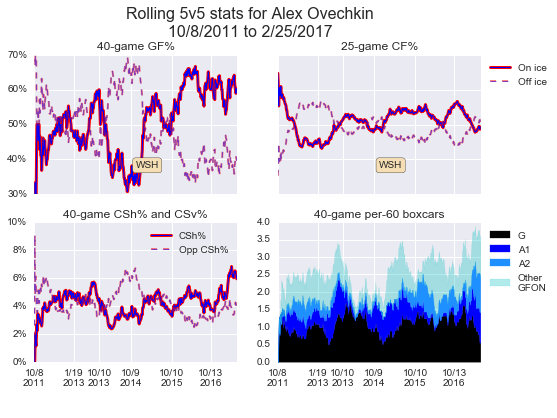

In [11]:
fig, axes = subplots(2, 2, sharex = True)

for i in range(len(indices_to_change_colors) - 1):
    starti = indices_to_change_colors[i]
    endi = indices_to_change_colors[i + 1]
    
    #GF%
    line = axes[0, 0].plot(df['GF%'].iloc[starti : endi + 1], c=color2[i], 
                lw=1)
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = axes[0, 0].plot(df['GF% Off'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    axes[0, 0].annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    #CF%
    line = axes[0, 1].plot(df['CF%'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='On ice')
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = axes[0, 1].plot(df['CF% Off'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='Off ice', ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    axes[0, 1].annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    if i == 0:
        axes[0, 1].legend(loc=2, bbox_to_anchor=(1, 1), fontsize=10)
    
    #Sh% and Sv%
    line = axes[1, 0].plot(df['CSh% On'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='CSh%')
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = axes[1, 0].plot(df['Opp CSh% On'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='Opp CSh%', ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    axes[1, 0].annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    if i == 0:
        axes[1, 0].legend(loc=1, fontsize = 10)
    
    
    
axes[0, 0].set_ylim(0.3, 0.7)
ys = arange(0.3, 0.71, 0.1)
axes[0, 0].set_yticks(ys)
axes[0, 0].set_yticklabels(['{0:.0f}%'.format(y*100) for y in ys])

axes[0, 1].set_ylim(0.3, 0.7)
axes[0, 1].set_yticks(ys)
axes[0, 1].set_yticklabels(['' for y in ys])

axes[1, 0].set_ylim(0, 0.1)
ys = arange(0, 0.11, 0.02)
axes[1, 0].set_yticks(ys)
axes[1, 0].set_yticklabels(['{0:.0f}%'.format(y*100) for y in ys])

if gapless:
    axes[0, 0].set_xlim(0, len(df))
    axes[0, 0].set_xticks(next_year_indices)
    axes[0, 0].set_xticklabels(next_year_dates, ha='left')
    axes[0, 1].set_xticklabels(next_year_dates, ha='left')
else:
    axes[0, 0].set_xlim(start_date2, end_date2)
    axes[0, 1].set_xlim(start_date2, end_date2)

axes[0, 0].set_title('{0:d}-game GF%'.format(roll_len_gf))
axes[0, 1].set_title('{0:d}-game CF%'.format(roll_len_cf))
axes[1, 0].set_title('{0:d}-game CSh% and CSv%'.format(roll_len_gf))

# Boxcars
axes[1, 1].fill_between(df.index, 0, df[base + 'G'], label='G', color='k')
axes[1, 1].fill_between(df.index, df[base + 'G'], df[base + 'G'] + df[base + 'A1'], label='A1', color='b')
axes[1, 1].fill_between(df.index, df[base + 'G'] + df[base + 'A1'], 
                        df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             label='A2', color='dodgerblue')
axes[1, 1].fill_between(df.index, df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             df[base + 'GFON_box'], label='Other\nGFON', color='c', alpha = 0.3)

if ratestats:
    axes[1, 1].set_title('{0:d}-game per-60 boxcars'.format(roll_len_boxcars))
    if pos == 'F':
        ypos = [0.85, 1.94, 2.7]
        ytext = ['L1 G', 'L1 P', 'L1 GF']
    elif pos == 'D':
        ypos = [0.17, 0.84, 2.5]
        ytext = ['P1 G', 'P1 P', 'P1 GF']
    #ylabs = ['{0:s}\n{1:.2f}'.format(t, p) for p, t in zip(ypos, ytext)]
    #axes[1, 1].set_yticks(ypos)
    #axes[1, 1].set_yticklabels(ylabs)
else:
    axes[1, 1].set_title('{0:d}-game boxcars'.format(roll_len_boxcars))

axes[1, 1].legend(loc=2, bbox_to_anchor=(1, 1), fontsize=10)
if ratestats:
    axes[1, 1].set_ylim(top=4)
else:
    axes[1, 1].set_ylim(top=round(0.75 * roll_len_boxcars))
    
titletext = 'Rolling 5v5 stats for {0:s}'.format(player)
titletext += '\n{0:s} to {1:s}'.format(format_timestamp_as_mdyy(start_date2).replace('\n', '/'),
                                       format_timestamp_as_mdyy(end_date2).replace('\n', '/'))
fig.suptitle(titletext, va='center', fontsize=16)

if save_file is not None:
    savefig(save_file)